## Testing Facebook Prophet timeseries forecasting on Uber data

Demonstration of the [Prophet](https://facebookincubator.github.io/prophet/) time series forecasting model on 14M New York Uber trips from January to June 2015.

The Prophet timeseries model fits the number of trips per day, using a trend,
a weekly component and a component fitting the impact of holidays (the yearly component is switched off).

In [1]:
import pandas as pd
from fbprophet import Prophet

In [2]:
datecol = 'Pickup_date'
df = pd.read_csv('data/uber-raw-data-janjune-15.csv', parse_dates=[datecol])

print('Number of data points =', len(df))

Number of data points = 14270479


In [3]:
df.head(2)

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID
0,B02617,2015-05-17 09:47:00,B02617,141
1,B02617,2015-05-17 09:47:00,B02617,65


In [4]:
# Create a new column for aggretating total number of trips by calendar day.
# See http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases
# for more information about Pandas 'offset aliases' for aggregating timeseries.

aggregationcol = 'num_trips'
df[aggregationcol] = pd.Series(1, index=df.index)

df_agg = df.groupby(pd.Grouper(key=datecol, freq='D')).sum()

print('Number of data points =', len(df_agg))
df_agg.head()

Number of data points = 181


,locationID,num_trips
Pickup_date,,
2015-01-01,8367368,58045
2015-01-02,6011112,40287
2015-01-03,8962831,59844
2015-01-04,6104609,41943
2015-01-05,6700781,43678


In [5]:
# Set up a dataframe in the format that Prophet expects it.
# ds is the time series, y is the variable to be predicted.

df_agg = df_agg.reset_index()
df_agg = df_agg[[datecol, aggregationcol]]
df_agg.columns = ['ds', 'y']

In [6]:
# Set up a Prophet model including holidays.

# Federal holidays from http://www.officeholidays.com/countries/usa/2015.php

federalholidays = pd.DataFrame({
  'holiday': 'federal',
  'ds': pd.to_datetime(['2015-01-01', '2015-01-19', '2015-05-26',
                        '2015-07-03', '2015-09-03', '2015-11-26',
                        '2015-12-25']),
  'lower_window': 0,
  'upper_window': 1,
})

m = Prophet(holidays=federalholidays, yearly_seasonality=False)

In [7]:
# Fit Prophet model to data.

m.fit(df_agg)

In [8]:
# Set up a dataframe for forecasting the timeseries.

future = m.make_future_dataframe(periods=120)
future.tail()

,ds
296,2015-10-24
297,2015-10-25
298,2015-10-26
299,2015-10-27
300,2015-10-28


In [9]:
# Make timeseries predictions.

forecast = m.predict(future)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
296,2015-10-24,136315.879307,124789.796210,147579.238627
297,2015-10-25,118584.987946,107553.219457,130058.731785
298,2015-10-26,109030.226591,98209.318134,120812.256228
299,2015-10-27,116424.417366,104752.388173,128815.643857
300,2015-10-28,120536.095055,108577.102050,132261.287792


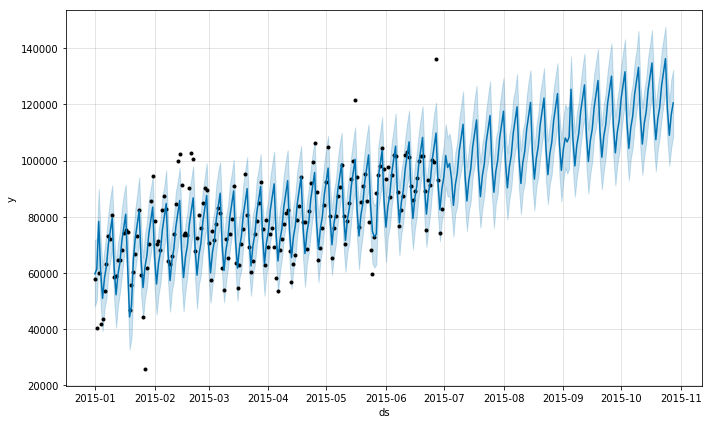

In [10]:
# Plot timeseries

m.plot(forecast)

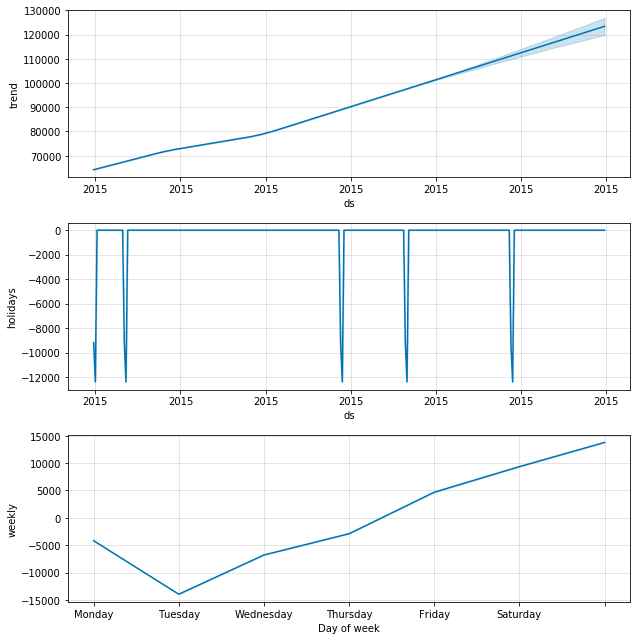

In [11]:
# Plot the components of the prediction.

m.plot_components(forecast)

In [14]:
# Second model including uncertainties in the weekly component
# and holidays, sampled via MCMC.

model = Prophet(mcmc_samples=500, holidays=federalholidays, yearly_seasonality=False)

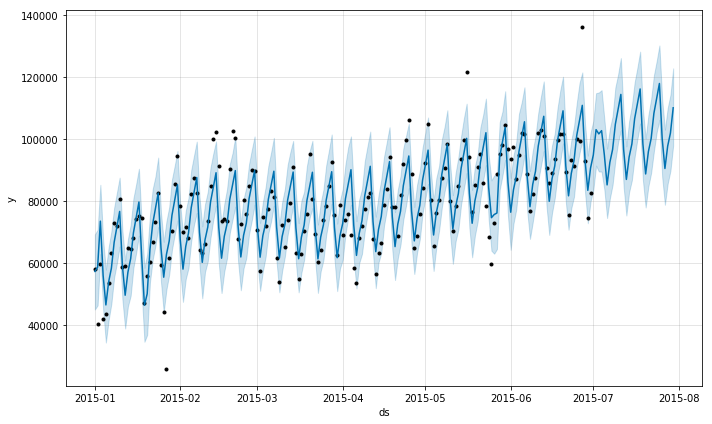

In [15]:
model.fit(df_agg)

future = model.make_future_dataframe(periods=30)

forecast = model.predict(future)
model.plot(forecast)

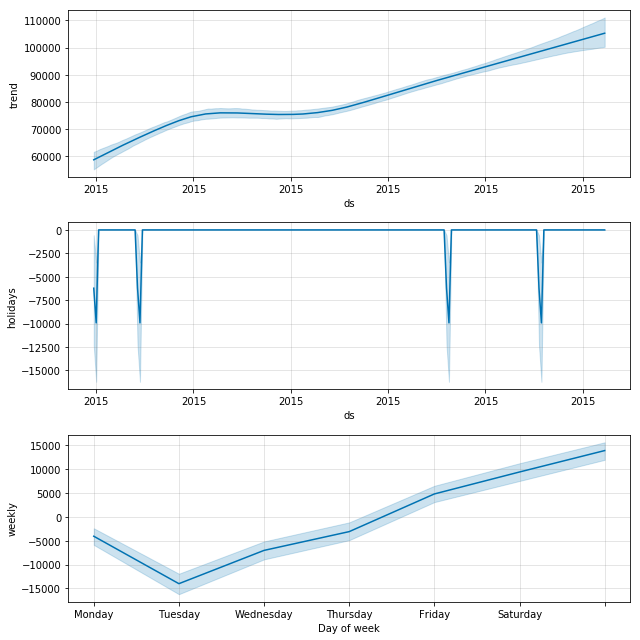

In [16]:
model.plot_components(forecast)